## SVD/PCA/NMF and choosing the best k (reduced feature dimension)

In [29]:
import os
import sys
parent_dr = os.path.split(os.getcwd())[0]
if parent_dr not in sys.path:
    sys.path.append(parent_dr)

In [30]:
%load_ext autoreload
%autoreload 2

import scipy.sparse as sp
import scipy.linalg as sla
import pandas as pd
from sklearn.decomposition import NMF, TruncatedSVD
import numpy.linalg as la
import matplotlib . pyplot as plt # plots
from time import time
from core.data.arxiv_data_io import *
from core.data.text.tf_idf_helpers import *
from core.matrix.svd_decomposition_helpers import *
from core.matrix.nmf_decompositions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [4]:
#reading in the full arXiv subset df
file_name = "tokenized_arxiv_subset_15540.pkl"
full_path = os.path.join(parent_dr, "core", "resources", file_name)
data_df = pd.read_pickle(full_path)

In [5]:
data_df.head(n=2)

,id,authors,title,categories,abstract,update_dt,clean,tokens
0,0704.0648,Kaushik Majumdar,Behavioral response to strong aversive stimuli: A neurodynamical model,q-bio.NC,"In this paper a theoretical model of functioning of a neural circuit during a\nbehavioral response has been proposed. A neural circuit can be thought of as a\ndirected multigraph whose each vertex is a neuron and each edge is a synapse.\nIt has been assumed in this paper that the behavior of such circuits is\nmanifested through the collective behavior of neurons belonging to that\ncircuit. Behavioral information of each neuron is contained in the coefficients\nof the fast Fourier transform (FFT) over the output spike train. Those\ncoefficients form a vector in a multidimensional vector space. Behavioral\ndynamics of a neuronal network in response to strong aversive stimuli has been\nstudied in a vector space in which a suitable pseudometric has been defined.\nThe neurodynamical model of network behavior has been formulated in terms of\nexisting memory, synaptic plasticity and feelings. The model has an analogy in\nclassical electrostatics, by which the notion of force and potential energy has\nbeen introduced. Since the model takes input from each neuron in a network and\nproduces a behavior as the output, it would be extremely difficult or may even\nbe impossible to implement. But with the help of the model a possible\nexplanation for an hitherto unexplained neurological observation in human brain\nhas been offered. The model is compatible with a recent model of sequential\nbehavioral dynamics. The model is based on electrophysiology, but its relevance\nto hemodynamics has been outlined.\n",2007-05-23,in this paper a theoretical model of functioning of a neural circuit during a behavioral response has been proposed a neural circuit can be thought of as a directed multigraph whose each vertex is a neuron and each edge is a synapse it has been assumed in this paper that the behavior of such circuits is manifested through the collective behavior of neurons belonging to that circuit behavioral information of each neuron is contained in the coefficients of the fast fourier transform fft over the output spike train those coefficients form a vector in a multidimensional vector space behavioral dynamics of a neuronal network in response to strong aversive stimuli has been studied in a vector space in which a suitable pseudometric has been defined the neurodynamical model of network behavior has been formulated in terms of existing memory synaptic plasticity and feelings the model has an analogy in classical electrostatics by which the notion of force and potential energy has been introduced since the model takes input from each neuron in a network and produces a behavior as the output it would be extremely difficult or may even be impossible to implement but with the help of the model a possible explanation for an hitherto unexplained neurological observation in human brain has been offered the model is compatible with a recent model of sequential behavioral dynamics the model is based on electrophysiology but its relevance to hemodynamics has been outlined,"[paper, theoretical, model, functioning, neural, circuit, behavioral, response, propose, neural, circuit, think, direct, multigraph, vertex, neuron, edge, synapse, assume, paper, behavior, circuit, manifest, collective, behavior, neuron, belong, circuit, behavioral, information, neuron, contain, coefficient, fast, fourier, transform, fft, output, spike, train, coefficient, form, vector, multidimensional, vector, space, behavioral, dynamic, neuronal, network, response, strong, aversive, stimulus, study, vector, space, suitable, pseudometric, define, neurodynamical, model, network, behavior, formulate, term, exist, memory, synaptic, plasticity, feeling, model, analogy, classical, electrostatic, notion, force, potential, energy, introduce, model, take, input, neuron, network, produce, behavior, output, extremely, d

In [6]:
# splitting out the test and train dfs
train_df, test_df = sample_arxiv_data_by_category(data_df)
assert len(train_df)/len(data_df) == 0.8

In [7]:
print(f'The training df has dimensions {train_df.shape}')
print(f'The testing df has dimensions {test_df.shape}')

The training df has dimensions (12432, 9)
The testing df has dimensions (3108, 9)


### Compute TF-IDF Matrix

In [8]:
# fit the tfidf object
train_tokens = train_df['tokens']
tfidf_obj, index_to_word = fit_tfidf(train_df['tokens'])

In [9]:
print(f'tfidf_obj is a {type(tfidf_obj)} \n with a vocabulary of {len(index_to_word)} words')

tfidf_obj is a <class 'sklearn.feature_extraction.text.TfidfVectorizer'> 
 with a vocabulary of 30460 words


In [10]:
# generate the tfidf matrix for the training data
tfidf_train_matrix, index_to_doc = transform_tfidf(train_df,tfidf_obj=tfidf_obj)

In [11]:
print(f'The TF-IDF matrix is a sparse matrix with dimensions: {tfidf_train_matrix.shape}')

The TF-IDF matrix is a sparse matrix with dimensions: (12432, 30460)


### NMF Decomposition

In [15]:
# This will take a few minutes

kvals_simple = list(range(1,100,10))
simple_results = nmf_k_search(tfidf_train_matrix, kvals_simple)
simple_results

Now fitting NMF for k =1...
[1, 110.14452881562842, 7, 0.139725923538208]
Now fitting NMF for k =11...
[11, 107.91344005912548, 84, 1.0930120944976807]
Now fitting NMF for k =21...
[21, 106.65444060143894, 102, 2.466398000717163]
Now fitting NMF for k =31...
[31, 105.64561412128835, 216, 8.840849876403809]
Now fitting NMF for k =41...
[41, 104.85066663282167, 191, 14.576015949249268]
Now fitting NMF for k =51...
[51, 104.13117787951383, 274, 29.192205905914307]
Now fitting NMF for k =61...
[61, 103.48323030595336, 117, 19.17770504951477]
Now fitting NMF for k =71...
[71, 102.8995530403503, 173, 44.91907000541687]
Now fitting NMF for k =81...
[81, 102.35225469096571, 192, 66.88933610916138]
Now fitting NMF for k =91...
[91, 101.82173660291447, 273, 125.00171995162964]


,k,Reconstruction Error,Iterations to convergence,Time to converge (secs)
0,1,110.144529,7,0.139726
1,11,107.913440,84,1.093012
2,21,106.654441,102,2.466398
3,31,105.645614,216,8.840850
4,41,104.850667,191,14.576016
5,51,104.131178,274,29.192206
6,61,103.483230,117,19.177705
7,71,102.899553,173,44.919070
8,81,102.352255,192,66.889336
9,91,101.821737,273,125.001720


In [12]:
# Don't run this code it will take a very long time

# larger_k_vals = [150, 200, 300, 600, 1000, 15000]
# larger_k_results = nmf_k_search(tfidf_train_matrix, larger_k_vals)
# larger_k_results

In [21]:
# matrix reconstruction error for serialized k = 2299
W_2299 = np.load("output/W_2299.pkl", allow_pickle=True)
H_2299 = np.load("output/H_2299.pkl", allow_pickle=True)
X_r = W_2299 @ H_2299
err_2299 = la.norm(tfidf_train_matrix - X_r, ord='fro')
print(f'Reconstruction error for NMF k = 2299 is : {err_2299}')

Reconstruction error for NMF k = 2299 is : 60.512932882382444


In [22]:
#results from larger k's that I didn't save else where
nmf_larger_results = [[150, 99.06062880181726, 243, 277.3060259819031],
                 [200, 97.01359152285178, 305, 625.0525093078613],
                 [300, 93.5664692723195, 236, 2153.6644287109375],
                 [600, 85.76961768114077, 119, 1938.1206359863281],
                 [1000, 77.81929157478947, 105, 4577.196753978729],
                 [2299, 60.512932882382444, np.nan,np.nan]]


nmf_larger_results_df = pd.DataFrame(nmf_larger_results, columns=['k', 'Reconstruction Error',
                                                'Iterations to convergence',
                                                'Time to converge (secs)'])
nmf_full_results_df = simple_results.append(nmf_larger_results_df)
nmf_full_results_df

,k,Reconstruction Error,Iterations to convergence,Time to converge (secs)
0,1,110.144529,7.0,0.139726
1,11,107.913440,84.0,1.093012
2,21,106.654441,102.0,2.466398
3,31,105.645614,216.0,8.840850
4,41,104.850667,191.0,14.576016
5,51,104.131178,274.0,29.192206
6,61,103.483230,117.0,19.177705
7,71,102.899553,173.0,44.919070
8,81,102.352255,192.0,66.889336
9,91,101.821737,273.0,125.001720


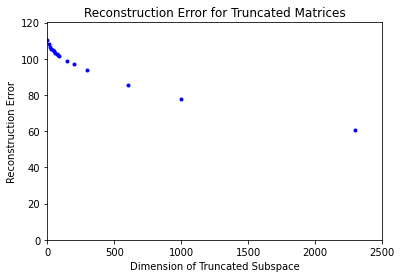

In [26]:
fig1 = plt.figure(23)
ax1 = plt.subplot(111)
ax1.plot(
    nmf_full_results_df.iloc[:,0], nmf_full_results_df.iloc[:,1], 'b.')
ax1.set_title('Reconstruction Error for Truncated Matrices')
ax1.set_xlabel('Dimension of Truncated Subspace')
ax1.set_ylabel('Reconstruction Error')
ax1.axis([0, 2500 , 0, max(nmf_full_results_df.iloc[:,1]) + 10])
plt.show()

#### Computing and serializing NMF for larger values of k

In [18]:

#big_k_nmf = [1024, 2048, 4096, 8192, 12431]
#nmf_k_search(tfidf_train_matrix, big_k_nmf, serialize=True)

### SVD

#### Computing the Full SVD
The internet said that scipy's svd implementation of SVD is faster than numpy's so using that

In [13]:
# Code for computing the full SVD of the sparse matrix
# This took about an hour

print("computing full SVD of the sparse tfidf matrix...")
t0 = time()
U_, sigmas_, V_T_ = sp.linalg.svds(tfidf_train_matrix,k=12431,which='LM', maxiter=None)
time_elapsed = time() - t0
print(f"SVD complete in {time_elapsed} seconds")

computing full SVD of the sparse tfidf matrix...
SVD complete in 3252.1491236686707 seconds


In [15]:
print(f'U_ has dimensions: {U_.shape}')
print(f'V_T_ has dimensions:{V_T_.shape}')
print(f'Number of singluar values:{sigmas_.shape}')

U_ has dimensions: (12432, 12431)
V_T_ has dimensions:(12431, 30460)
Number of singluar values:(12431,)


In [16]:
reconstruc_u = U_ @ np.diag(sigmas_) @ V_T_
reconstruction_err_u = la.norm(tfidf_train_matrix - reconstruc_u, ord='fro')

1.6606730721042668e-12

In [18]:
print(f'Reconstruction error using the full SVD: {reconstruction_err_u}')

Reconstruction error using the full SVD: 1.6606730721042668e-12


### Serializing the full SVD matrices

Scipy sparse SVD returns the singular values and vectors in reverse order (smallest singular values first). So first need to reverse the order of everything
https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html

In [19]:
# function in core/matrix/svd_decomposition_helpers that fixes the order
U_full, sigmas_full, V_T_full = fix_scipy_svds(U_, sigmas_,V_T_)

In [20]:
print(f'U_full has dimensions: {U_full.shape}')
print(f'V_T_full has dimensions:{V_T_full.shape}')
print(f'Number of singluar values:{sigmas_full.shape}')

U_full has dimensions: (12432, 12431)
V_T_full has dimensions:(12431, 30460)
Number of singluar values:(12431,)


Now serialize these reordered matrices

In [24]:
#serialize full SVD

output_file_names = ["tfidf_train_full_svd_U.pkl",
                     "tfidf_train_full_svd_sigmas.pkl",
                      "tfidf_train_full_svd_V_T.pkl"]

serialize_SVD(U_full, sigmas_full, V_T_full, output_file_names)

In [25]:
def compute_size(input_array):
    size = input_array.size
    item_size = input_array.itemsize
    num_bytes = size * item_size
    num_mb = num_bytes / 1000000
    return num_mb

In [26]:
# checking the size of the V_T array
print(compute_size(V_T_full))

3029.18608


### Finding the optimal k with now that we have the full SVD
First read in the full SVD matrice we found above

In [27]:
# Reading in the matrices we just serialized for reproducibility's sake

U_from_pkl = np.load("output/tfidf_train_full_svd_U.pkl", allow_pickle=True)
V_T_from_pkl = np.load("output/tfidf_train_full_svd_V_T.pkl", allow_pickle=True)
sigmas_from_pkl = np.load("output/tfidf_train_full_svd_sigmas.pkl", allow_pickle=True)


print(f'U_from_pkl has dimensions: {U_from_pkl.shape}')
print(f'V_T_from_pkl has dimensions:{V_T_from_pkl.shape}')
print(f'Number of singluar values:{sigmas_from_pkl.shape}')

U_from_pkl has dimensions: (12432, 12431)
V_T_from_pkl has dimensions:(12431, 30460)
Number of singluar values:(12431,)


In [33]:
nmf_test_kvals =[1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 150, 200, 300, 600,1000, 2299]
svd_results_df = svd_k_search(U_from_pkl, sigmas_from_pkl, V_T_from_pkl, nmf_test_kvals)
# attach NMF results for comparison
results_df = svd_results_df.rename(columns={'Reconstruction Error': 'SVD Reconstruction Err'})
results_df['NMF_Reconstruction_Err'] = list(nmf_full_results_df['Reconstruction Error'])
results_df


,k,SVD Reconstruction Err,NMF_Reconstruction_Err
0,1,110.144529,110.144529
1,11,107.779599,107.913440
2,21,106.439330,106.654441
3,31,105.399028,105.645614
4,41,104.534186,104.850667
5,51,103.763963,104.131178
6,61,103.062262,103.483230
7,71,102.412272,102.899553
8,81,101.802566,102.352255
9,91,101.220245,101.821737


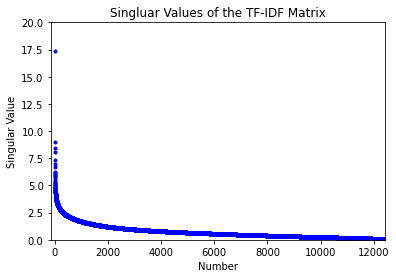

In [34]:
fig2 = plt.figure(23)
ax2 = plt.subplot(111)
ax2.plot(
    np.arange(1,12432,1), sigmas_from_pkl, 'b.')
ax2.set_title('Singluar Values of the TF-IDF Matrix')
ax2.set_xlabel('Number')
ax2.set_ylabel('Singular Value')
ax2.axis([-150, 12432 , 0, 20])
plt.show()

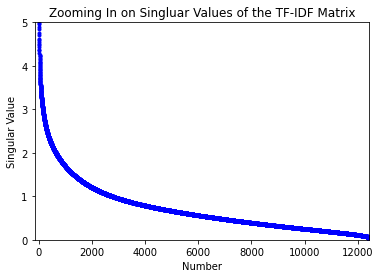

In [35]:
fig3 = plt.figure(23)
ax3 = plt.subplot(111)
ax3.plot(
    np.arange(1,12432,1), sigmas_from_pkl, 'b.')
ax3.set_title('Zooming In on Singluar Values of the TF-IDF Matrix')
ax3.set_xlabel('Number')
ax3.set_ylabel('Singular Value')
ax3.axis([-150, 12432 , 0, 5])
plt.show()

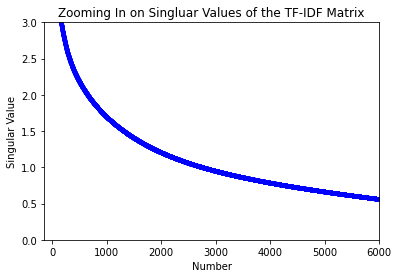

In [36]:
fig4 = plt.figure(23)
ax4 = plt.subplot(111)
ax4.plot(
    np.arange(1,12432,1), sigmas_from_pkl, 'b.')
ax4.set_title('Zooming In on Singluar Values of the TF-IDF Matrix')
ax4.set_xlabel('Number')
ax4.set_ylabel('Singular Value')
ax4.axis([-150, 6000 , 0, 3])
plt.show()

Based on these plots, there's no obvious "elbow" to the scree plot.

In [41]:
# Computing SVD reconstruction error for every value of k
err_df = pd.DataFrame(np.arange(1,12432,1),columns=['k'])
err_df['recon_err'] = err_df['k'].apply(lambda x : compute_truncated_svd_recon_err(sigmas_from_pkl,x))
total_recon_err = compute_truncated_svd_recon_err(sigmas_from_pkl,0)
err_df['pct_explained'] = 1 - (err_df['recon_err'] / total_recon_err)
err_df.tail(6)

,k,recon_err,pct_explained
12425,12426,0.00502,0.999955
12426,12427,0.00000,1.000000
12427,12428,0.00000,1.000000
12428,12429,0.00000,1.000000
12429,12430,0.00000,1.000000
12430,12431,0.00000,1.000000


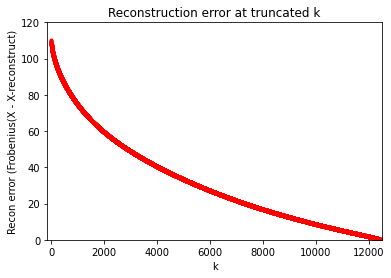

In [44]:
fig5 = plt.figure(23)
ax5 = plt.subplot(111)
ax5.plot(
    err_df['k'], err_df['recon_err'], 'r.')
ax5.set_title('Reconstruction error at truncated k')
ax5.set_xlabel('k')
ax5.set_ylabel('Recon error (Frobenius(X - X-reconstruct)')
ax5.axis([-150, 12500 , 0, 120])
plt.show()

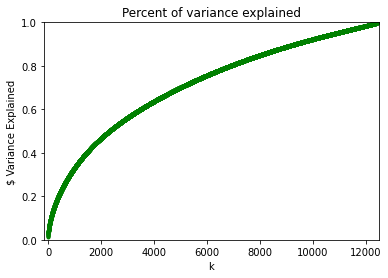

In [47]:
fig6 = plt.figure(23)
ax6 = plt.subplot(111)
ax6.plot(
    err_df['k'], err_df['pct_explained'], 'g.')
ax6.set_title('Percent of variance explained')
ax6.set_xlabel('k')
ax6.set_ylabel('$ Variance Explained')
ax6.axis([-150, 12500 , 0, 1])
plt.show()

/var/folders/yq/5fk4pl911495z8dhwm2zjsqc0000gn/T/ipykernel_4302/2679304936.py:4: RuntimeWarning: divide by zero encountered in log
  np.arange(1,12432,1), np.log(sigmas_from_pkl), 'b.')


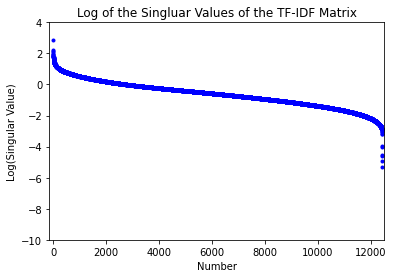

In [48]:
fig2 = plt.figure(23)
ax2 = plt.subplot(111)
ax2.plot(
    np.arange(1,12432,1), np.log(sigmas_from_pkl), 'b.')
ax2.set_title('Log of the Singluar Values of the TF-IDF Matrix')
ax2.set_xlabel('Number')
ax2.set_ylabel('Log(Singular Value)')
ax2.axis([-150, 12500 , -10, 4])
plt.show()

In [51]:
# Computing optimal k based on Singular Value Hard Thresholding method
# Code is adapted from: http://www.pyrunner.com/weblog/2016/08/01/optimal-svht/
def omega_approx(beta):
    """Return an approximate omega value for given beta. Equation (5) from Gavish 2014."""
    return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

def svht(X, sigma=None, sv=None):
    """
    Return the optimal singular value hard threshold (SVHT) value.
    `X` is any m-by-n matrix. 
    `sv` is the vector of singular values 
    """

    try:
        m,n = sorted(X.shape) # ensures m <= n
    except:
        raise ValueError('invalid input matrix')
    beta = m / n # ratio between 0 and 1
    sv = np.squeeze(sv)
    if sv.ndim != 1:
        raise ValueError('vector of singular values must be 1-dimensional')
    return np.median(sv) * omega_approx(beta)


In [56]:
tau = svht(tfidf_train_matrix, sv=sigmas_from_pkl)
print(f'The threshold value for singular values is {tau}')

The threshold value for singular values is 1.1145142456140364


In [58]:
tau_k = (sigmas_from_pkl > tau).sum()
print(f"The full SVD has {tau_k} singular values greater than {tau}")

The full SVD has 2299 singular values greater than 1.1145142456140364
